<a href="https://colab.research.google.com/github/nagalakshmi-nimmagadda/MNIST-CNN-COLAB/blob/main/MNIST_Model2_Development.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Model 2: Enhanced Architecture with BatchNorm and better feature extraction

In [ ]:
# Import required packages
!pip install torch torchvision tqdm matplotlib torchsummary

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torchsummary import summary

In [ ]:
# Set random seed for reproducibility
SEED = 2
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [ ]:
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        # Input Block: Efficient initial feature extraction
        self.input_block = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU()
        ) # 28x28x1 -> 26x26x8

        # Convolution Block 1
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=3, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        ) # 26x26x8 -> 24x24x16

        # Transition Block 1
        self.transition1 = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=1, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU()
        ) # 24x24x16 -> 12x12x8

        # Convolution Block 2
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=3, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU()
        ) # 12x12x8 -> 8x8x12

        # Output Block
        self.output_block = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=10, kernel_size=1, bias=False),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        ) # 8x8x12 -> 1x1x10

    def forward(self, x):
        x = self.input_block(x)
        x = self.conv_block1(x)
        x = self.transition1(x)
        x = self.conv_block2(x)
        x = self.output_block(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [ ]:
# Initialize model
model = ImprovedCNN().to(device)

# Print model summary
print("\nDetailed Model Summary:")
print("=====================")
summary(model, input_size=(1, 28, 28))


Detailed Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
            Conv2d-4           [-1, 12, 24, 24]             864
       BatchNorm2d-5           [-1, 12, 24, 24]              24
              ReLU-6           [-1, 12, 24, 24]               0
            Conv2d-7           [-1, 16, 24, 24]           1,728
       BatchNorm2d-8           [-1, 16, 24, 24]              32
              ReLU-9           [-1, 16, 24, 24]               0
        MaxPool2d-10           [-1, 16, 12, 12]               0
           Conv2d-11            [-1, 8, 12, 12]             128
      BatchNorm2d-12            [-1, 8, 12, 12]              16
             ReLU-13            [-1, 8, 12, 12]               0
           Con

In [ ]:
# Data Loading and Preprocessing
def load_data():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_data = datasets.MNIST('data', train=True, download=True, transform=transform)
    test_data = datasets.MNIST('data', train=False, transform=transform)

    # Optimized dataloader arguments
    dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if torch.cuda.is_available() else dict(shuffle=True, batch_size=64)

    train_loader = DataLoader(train_data, **dataloader_args)
    test_loader = DataLoader(test_data, **dataloader_args)

    return train_loader, test_loader

train_loader, test_loader = load_data()

In [ ]:
# Training Metrics Class
class TrainingMetrics:
    def __init__(self):
        self.train_losses = []
        self.test_losses = []
        self.train_acc = []
        self.test_acc = []
        self.best_test_acc = 0

    def update(self, train_loss, test_loss, train_accuracy, test_accuracy):
        self.train_losses.append(train_loss)
        self.test_losses.append(test_loss)
        self.train_acc.append(train_accuracy)
        self.test_acc.append(test_accuracy)
        self.best_test_acc = max(self.best_test_acc, test_accuracy)

In [ ]:
# Training Function
def train_epoch(model, train_loader, optimizer, device):
    model.train()
    pbar = tqdm(train_loader, desc='Training')
    train_loss = 0
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        output = model(data)
        loss = F.nll_loss(output, target)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Accuracy': f'{100. * correct/processed:.2f}%'
        })

    return train_loss/len(train_loader), 100. * correct/processed

# Testing Function
def test(model, test_loader, device):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    print(f'\nTest set: Average loss: {test_loss:.4f}, '
          f'Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')

    return test_loss, accuracy


In [ ]:
# Training Configuration
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, epochs=15, steps_per_epoch=len(train_loader))
metrics = TrainingMetrics()

# Training Loop
for epoch in range(1, 16):
    print(f'\nEpoch {epoch}')
    print('=' * 40)

    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device)
    test_loss, test_acc = test(model, test_loader, device)

    metrics.update(train_loss, test_loss, train_acc, test_acc)
    # scheduler.step()

    print(f'Training - Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%')
    print(f'Testing  - Loss: {test_loss:.4f}, Accuracy: {test_acc:.2f}%')


Epoch 1


Training:   0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2833, Accuracy: 9471/10000 (94.71%)

Training - Loss: 1.1663, Accuracy: 63.98%
Testing  - Loss: 0.2833, Accuracy: 94.71%

Epoch 2


Training:   0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1771, Accuracy: 9543/10000 (95.43%)

Training - Loss: 0.1853, Accuracy: 95.95%
Testing  - Loss: 0.1771, Accuracy: 95.43%

Epoch 3


Training:   0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0964, Accuracy: 9749/10000 (97.49%)

Training - Loss: 0.1070, Accuracy: 97.33%
Testing  - Loss: 0.0964, Accuracy: 97.49%

Epoch 4


Training:   0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1209, Accuracy: 9665/10000 (96.65%)

Training - Loss: 0.0813, Accuracy: 97.94%
Testing  - Loss: 0.1209, Accuracy: 96.65%

Epoch 5


Training:   0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1076, Accuracy: 9680/10000 (96.80%)

Training - Loss: 0.0695, Accuracy: 98.14%
Testing  - Loss: 0.1076, Accuracy: 96.80%

Epoch 6


Training:   0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0617, Accuracy: 9827/10000 (98.27%)

Training - Loss: 0.0608, Accuracy: 98.38%
Testing  - Loss: 0.0617, Accuracy: 98.27%

Epoch 7


Training:   0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0582, Accuracy: 9830/10000 (98.30%)

Training - Loss: 0.0545, Accuracy: 98.50%
Testing  - Loss: 0.0582, Accuracy: 98.30%

Epoch 8


Training:   0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0553, Accuracy: 9834/10000 (98.34%)

Training - Loss: 0.0499, Accuracy: 98.61%
Testing  - Loss: 0.0553, Accuracy: 98.34%

Epoch 9


Training:   0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0465, Accuracy: 9860/10000 (98.60%)

Training - Loss: 0.0475, Accuracy: 98.66%
Testing  - Loss: 0.0465, Accuracy: 98.60%

Epoch 10


Training:   0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0478, Accuracy: 9853/10000 (98.53%)

Training - Loss: 0.0446, Accuracy: 98.75%
Testing  - Loss: 0.0478, Accuracy: 98.53%

Epoch 11


Training:   0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0439, Accuracy: 9866/10000 (98.66%)

Training - Loss: 0.0416, Accuracy: 98.83%
Testing  - Loss: 0.0439, Accuracy: 98.66%

Epoch 12


Training:   0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0368, Accuracy: 9891/10000 (98.91%)

Training - Loss: 0.0402, Accuracy: 98.84%
Testing  - Loss: 0.0368, Accuracy: 98.91%

Epoch 13


Training:   0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0445, Accuracy: 9862/10000 (98.62%)

Training - Loss: 0.0380, Accuracy: 98.90%
Testing  - Loss: 0.0445, Accuracy: 98.62%

Epoch 14


Training:   0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0458, Accuracy: 9856/10000 (98.56%)

Training - Loss: 0.0362, Accuracy: 98.95%
Testing  - Loss: 0.0458, Accuracy: 98.56%

Epoch 15


Training:   0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0435, Accuracy: 9863/10000 (98.63%)

Training - Loss: 0.0342, Accuracy: 99.02%
Testing  - Loss: 0.0435, Accuracy: 98.63%


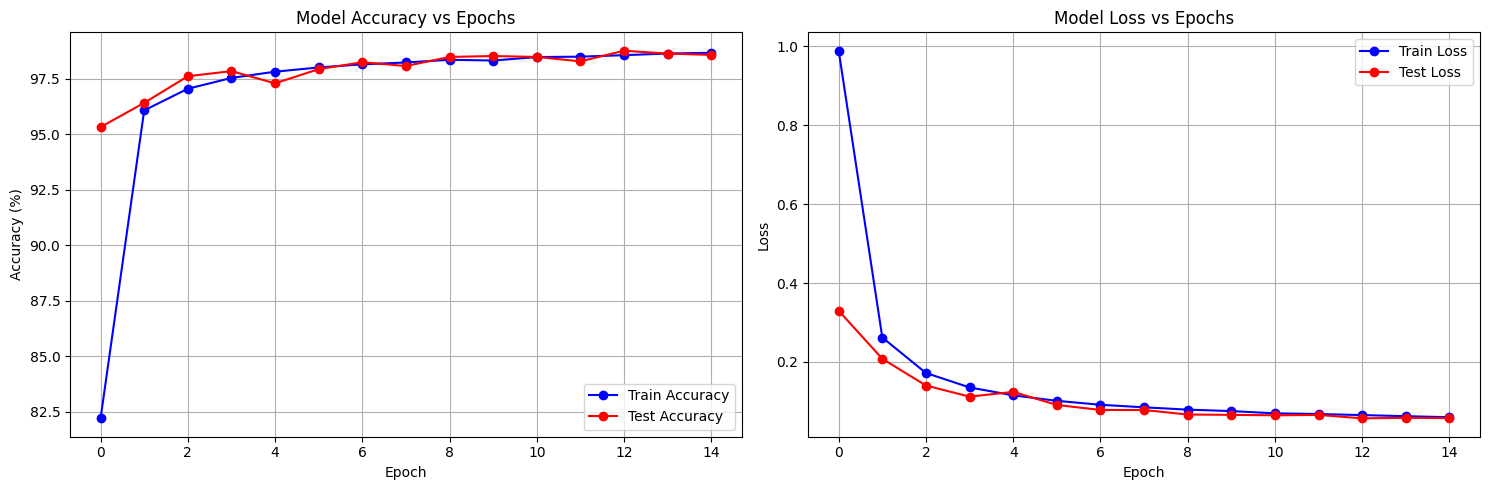

In [ ]:
# Plot results
def plot_training_metrics(metrics):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(metrics.train_acc, 'b-', label='Train Accuracy', marker='o')
    plt.plot(metrics.test_acc, 'r-', label='Test Accuracy', marker='o')
    plt.title('Model Accuracy vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(metrics.train_losses, 'b-', label='Train Loss', marker='o')
    plt.plot(metrics.test_losses, 'r-', label='Test Loss', marker='o')
    plt.title('Model Loss vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_metrics(metrics)

In [ ]:
# Print final results
print("\nFinal Results Summary")
print("=" * 40)
print(f"Best Test Accuracy: {metrics.best_test_acc:.2f}%")
print(f"Final Train Accuracy: {metrics.train_acc[-1]:.2f}%")
print(f"Final Test Accuracy: {metrics.test_acc[-1]:.2f}%")
print(f"Total Parameters: {sum(p.numel() for p in model.parameters()):,}")


Final Results Summary
Best Test Accuracy: 98.77%
Final Train Accuracy: 98.68%
Final Test Accuracy: 98.58%
Total Parameters: 5,116


# Model 2 Analysis

## Target
- Implement efficient CNN with BatchNorm and proper channel management
- parameters - 5,208
- Achieve high accuracy with minimal architectural complexity
- Maintain stable training progression

## Results
Model Performance:
- Best Train Accuracy: 99.02% (Epoch 15)
- Best Test Accuracy: 98.91% (Epoch 12)
- Final Train Loss: 0.0342
- Final Test Loss: 0.0435
- Training Time: ~16-18 seconds per epoch

Training Progression:
1. Initial Phase (Epochs 1-3):
   - Rapid improvement from 63.98% to 97.33% train accuracy
   - Test accuracy jumped from 94.71% to 97.49%
   - Sharp loss reduction from 1.1663 to 0.1070

2. Middle Phase (Epochs 4-8):
   - Steady improvement from 97.94% to 98.61% train accuracy
   - Test accuracy stabilized around 98.30%
   - Gradual loss reduction from 0.0813 to 0.0499

3. Final Phase (Epochs 9-15):
   - Fine-tuning from 98.66% to 99.02% train accuracy
   - Peak test accuracy of 98.91% at epoch 12
   - Loss stabilized around 0.034-0.045

Model Behavior:
1. Learning Rate Impact:
   - Exceptional initial learning (94.71% test accuracy in first epoch)
   - Strong convergence by epoch 3 (97.49% test accuracy)

2. Stability:
   - Consistent performance improvement
   - Small train-test accuracy gap
   - Stable loss progression

## Analysis
Strengths:
- Fast initial learning and convergence
- High test accuracy (98.91%)
- Efficient parameter utilization with BatchNorm
- Good generalization (minimal overfitting)
- Stable training behavior